In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Check device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [73]:
file_path = "./magic+gamma+telescope/magic04.data"
column_names = [
    "fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans",
    "fAlpha", "fDist", "class"
]
data = pd.read_csv(file_path, header=None, names=column_names)

data['class'] = data['class'].apply(lambda x: 0 if x == 'g' else 1)

X = data.drop('class', axis=1).values
y = data['class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [87]:
class GammaDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype(np.float32)  # Convert to float32
        self.y = y.astype(np.int64)    # Class labels as int64 (required by PyTorch)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Return a tuple of (features, label)
        features = self.X[idx]
        label = self.y[idx]
        return features, label

# Create Dataset instances
train_dataset = GammaDataset(X_train, y_train)
test_dataset = GammaDataset(X_test, y_test)

# Wrap with DataLoader
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Number of train batches:", len(train_loader))
print("Number of test batches:", len(test_loader))


Number of train batches: 60
Number of test batches: 15


In [88]:
class MagicGammaClassifier(nn.Module):
    def __init__(self):
        super(MagicGammaClassifier, self).__init__()
        self.fc1 = nn.Linear(10, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

In [89]:
model = MagicGammaClassifier()

In [90]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [91]:
train_losses = []
train_accuracies = []

In [92]:
def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for features, labels in train_loader:
            # Move to device
            features, labels = features.to(device), labels.to(device)

            # 1) Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            # 2) Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * features.size(0)

            # Calculate predictions
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = 100.0 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        if epoch % (num_epochs / 10) == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


In [93]:
train(100)

Epoch [1/100], Loss: 0.5916, Accuracy: 69.32%
Epoch [19/100], Loss: 0.3463, Accuracy: 85.65%
Epoch [37/100], Loss: 0.3261, Accuracy: 86.55%
Epoch [55/100], Loss: 0.3156, Accuracy: 86.95%
Epoch [73/100], Loss: 0.3077, Accuracy: 87.15%
Epoch [91/100], Loss: 0.2992, Accuracy: 87.62%


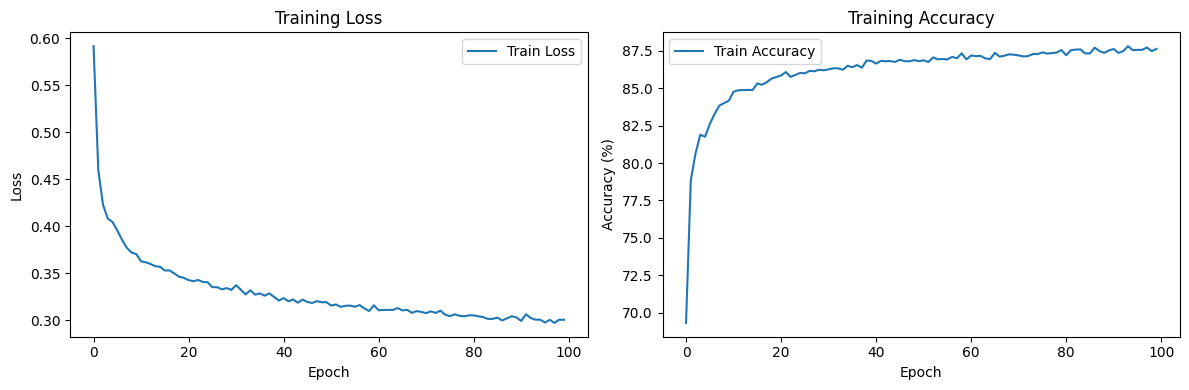

In [94]:
plt.figure(figsize=(12,4))

# Plot training loss
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()